# Загрузка данных и библиотек

In [3824]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics

%matplotlib inline

In [3825]:
df = pd.read_csv('main_task.csv')

# Анализ источника данных

In [3826]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


# Предобработка

#### Вспомогательные функции и переменные

In [3827]:
RANDOM_STATE = 42

date_pattern = re.compile('\d+/\d+/\d+')
today = pd.to_datetime('today').date()
min_date = pd.to_datetime('1900-01-01').date()

def describe_numerical(col, bins=100):
    """ Построение гистограммы и вывод основных статистических данных цифровых признаков"""

    df[col].hist(bins=bins)
    df[col].describe()


def describe_categorical(col):
    """ Вывод основных статистических данных категориальных признаков"""

    display(df[col].value_counts())
    display(df[col].describe())


def days_since_last_review(reviews):
    """Считает количество дней, прошедших со времени последнего отзыва"""

    review_dates = date_pattern.findall(reviews)
    last_review_date = min_date

    for review_date in review_dates:
        date = pd.to_datetime(review_date).date()

        if date > last_review_date:
            last_review_date = date

    return (today - last_review_date).days


def days_between_reviews(reviews):
    """Считает количество дней, прошедших между отзывами"""

    review_dates = date_pattern.findall(reviews)

    if len(review_dates) == 2:
        date1 = pd.to_datetime(review_dates[0]).date()
        date2 = pd.to_datetime(review_dates[1]).date()

        return abs((date1 - date2).days)

    return 0


def fill_cuisines(cuisines):
    """Преобразует строку, содержащую список в объект списка"""

    return ['Unknown'] if pd.isna(cuisines) else ast.literal_eval(cuisines)


def convert_price(price):
    """Преобразует строковое значение цены в числовое"""

    if price == '$':
        return 1
    elif price == '$$ - $$$':
        return 2
    elif price == '$$$$':
        return 3

# Анализ данных и создание признаков

## Аттрибут Restaurant_id

#### Анализ данных

In [3828]:
describe_categorical('Restaurant_id')

id_436      18
id_227      18
id_871      18
id_633      18
id_534      17
            ..
id_8021      1
id_8834      1
id_15338     1
id_9626      1
id_11315     1
Name: Restaurant_id, Length: 11909, dtype: int64

count      40000
unique     11909
top       id_436
freq          18
Name: Restaurant_id, dtype: object

#### Создание новых признаков

In [3829]:
# На основе данных анализа данных о Restaurant_id можем сделать вывод о наличии сетевых ресторанов
# и создать новый признак - является ли ресторан сетевым.

chain_restaurant = df['Restaurant_id'].value_counts().loc[lambda count: count > 1].index

df['Chain Restaurant'] = df['Restaurant_id'].apply(lambda r_id: 1 if r_id in chain_restaurant else 0)


## Аттрибут City

#### Анализ данных

In [3830]:
describe_categorical('City')

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

count      40000
unique        31
top       London
freq        5757
Name: City, dtype: object

#### Создание новых признаков

###### Является ли город столицей

In [3831]:
capitals = ['Paris','Stockholm','London','Berlin','Bratislava', 'Vienna','Rome',
            'Barcelona','Madrid','Dublin', 'Brussels','Warsaw','Budapest',
            'Copenhagen','Amsterdam','Hamburg','Lisbon','Prague','Oslo','Helsinki',
            'Ljubljana','Athens','Luxembourg']

df['Capital City'] = df['City'].apply(lambda city: 1 if city in capitals else 0)

###### Dummy-variables для городов

In [3832]:
city_ranges = pd.get_dummies(df['City'])

for c in city_ranges.columns:
    df[c] = city_ranges[c].values

## Аттрибут Cuisine Style

#### Анализ данных

In [3833]:
describe_categorical('Cuisine Style')

['Italian']                                                                                          1032
['French']                                                                                            805
['Spanish']                                                                                           695
['French', 'European']                                                                                405
['Cafe']                                                                                              403
                                                                                                     ... 
['Spanish', 'Seafood', 'Mediterranean', 'European', 'Vegetarian Friendly']                              1
['Asian', 'Thai', 'Pub']                                                                                1
['Lebanese', 'Fast Food', 'Mediterranean', 'Grill', 'Diner']                                            1
['Chinese', 'Asian', 'Delicatessen']          

count           30717
unique           9007
top       ['Italian']
freq             1032
Name: Cuisine Style, dtype: object

#### Очистка и преобразование данных, заполнение пропусков

In [3834]:
df['Cuisine Style'] = df['Cuisine Style'].apply(fill_cuisines)


#### Создание новых признаков

In [3835]:
df['Number of Cuisines'] = df['Cuisine Style'].apply(len)

## Аттрибут Ranking

#### Анализ данных

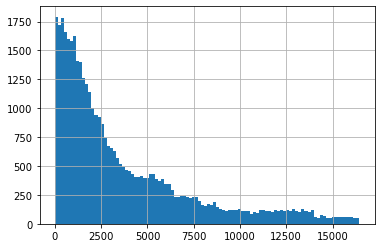

In [3836]:
describe_numerical('Ranking')


<AxesSubplot:>

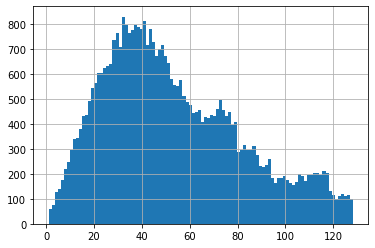

In [3837]:
# опытным путем выясняем, что взятие квадратного корня приводит данные к более нормальному виду, чем логарифм

np.sqrt(df['Ranking']).hist(bins=100)

#### Очистка и преобразование данных, заполнение пропусков


In [3838]:
# будем использовать в модели нормализованные данные

df['Ranking'] = df['Ranking'].apply(np.sqrt)


## Аттрибут Rating

#### Анализ данных

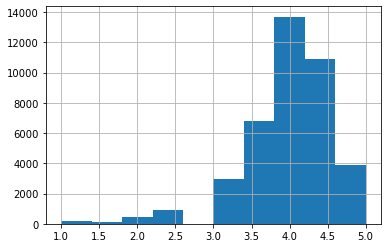

In [3839]:
describe_numerical('Rating', 10)


## Аттрибут Price Range

#### Анализ данных

In [3840]:
describe_categorical('Price Range')

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

count        26114
unique           3
top       $$ - $$$
freq         18412
Name: Price Range, dtype: object

#### Очистка и преобразование данных, заполнение пропусков

In [3841]:
# Заполним пропуски самым популярным значением

df['Price Range'] = df['Price Range'].fillna(df['Price Range'].value_counts().index[0])

# Попробуем преобразовать строковые значения.
# Это можно сделать двумя способами:

# Способ 1. Присвоение числового рангового значения, например $ - 1, $$-$$$ - 2, $$$$ - 3

# df['Price Range'] = df['Price Range'].apply(convert_price)

#### Создание новых признаков
###### Другой способ преобразования строковых значений цены

In [3842]:
price_ranges = pd.get_dummies(df['Price Range'])
price_ranges.columns = ['Inexpensive', 'Middle Price', 'Expensive']

for c in price_ranges.columns:
    df[c] = price_ranges[c].values

## Аттрибут Number of Reviews

#### Анализ данных

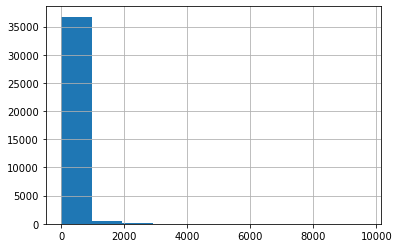

In [3843]:
describe_numerical('Number of Reviews', bins=10)


#### Очистка и преобразование данных, заполнение пропусков

<AxesSubplot:>

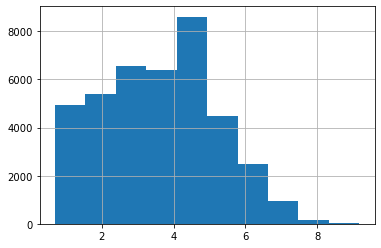

In [3844]:
# Заполним пропуски средним значением

df['Number of Reviews'] = df['Number of Reviews'].fillna(df['Number of Reviews'].mean())

# опытным путем выясняем, что взятие логарифма приводит данные к более нормальному виду

np.log(df['Number of Reviews']).hist(bins=10)

In [3845]:
# будем использовать в модели нормализованные данные
df['Number of Reviews'] = df['Number of Reviews'].apply(np.log)

## Аттрибут Reviews

#### Анализ данных

In [3846]:
describe_categorical('Reviews')


[[], []]                                                                                                                              6471
[['The real codido madrileño'], ['03/31/2017']]                                                                                          2
[['Healthy vegan doughnuts are posible', 'Best Vegan Donut in the world !!!'], ['11/17/2017', '11/16/2017']]                             2
[['Thursday snack', 'Good value for money & good food!'], ['03/13/2017', '06/20/2016']]                                                  2
[['Whenever in Madrid, we never miss this gem...', 'Underrated sushi restaurant with very good...'], ['04/11/2017', '12/02/2016']]       2
                                                                                                                                      ... 
[['Delicious cheesecake', "This year's most misleading description"], ['02/11/2016', '01/23/2016']]                                      1
[['Tasty fresh made ice cre

count        40000
unique       33516
top       [[], []]
freq          6471
Name: Reviews, dtype: object

#### Создание новых признаков

###### Количество дней между отзывами

In [3847]:
# df['Days Between Reviews'] = df['Reviews'].apply(days_between_reviews) # похоже, что признак немного ухудшает точность модели

###### Количество дней, прошедших с даты последнего отзыва

In [3848]:
df['Last Review Days'] = df['Reviews'].apply(days_since_last_review)

# Корреляция между признаками

<AxesSubplot:>

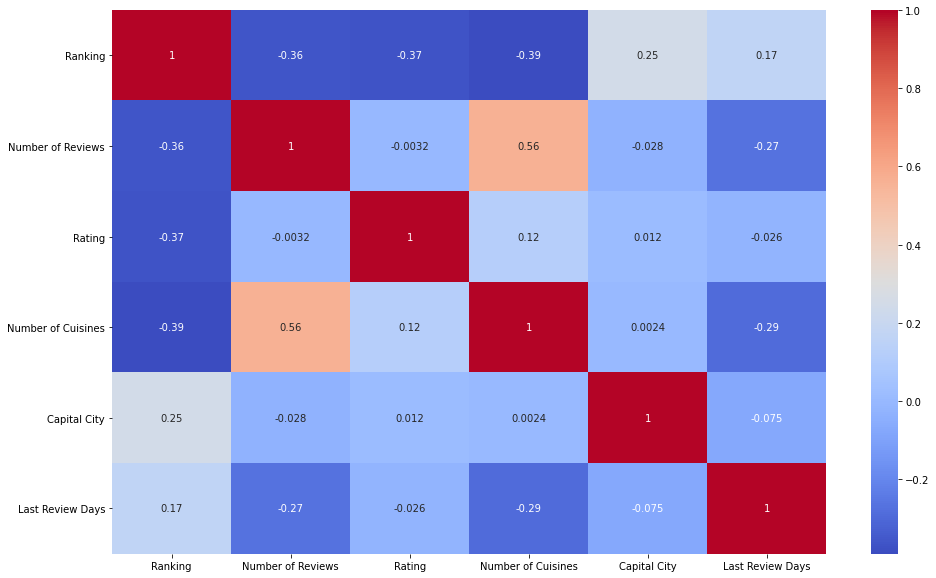

In [3849]:
plt.rcParams['figure.figsize'] = (16,10)
data_corr = df[['Cuisine Style', 'Ranking', 'Price Range', 'Number of Reviews',
                  'Reviews', 'Rating', 'Number of Cuisines', 'Capital City', 'Last Review Days']]
sns.heatmap(data_corr.corr(), annot=True, cmap='coolwarm')

# По графику можно сделать выовод о том, что сильной корреляции между целевой переменной и остальными признаками нет
# Однако можно наблюдать небольшую корреляцию между количеством кухонь и количеством отзывов

# Удаляем столбцы с dtype Object

In [3850]:
object_columns = []

for c in df.columns:
    if(df[c].dtype == 'object' and c != 'Restaurant_id'):
        object_columns.append(c)

df.drop(object_columns, axis=1, inplace=True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [3851]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [3852]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Создаём, обучаем и тестируем модель

In [3853]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [3854]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21290899999999996
